# Some examples of how to use the SEVIR generators

The SEVIR dataset is approximately 1TB in size and thus is too large to load directly into memory.  This tutorial shows the `SEVIRGenerator` class which can be used to generate samples from SEVIR.

SEVIR is based on HDF5 data files.   In general, streaming data directly from these files into a model for training is quite slow if you are doing a lot of random reads from the HDF files.   It is recommended that you first rewrite your desired dataset into contiguous blocks using `SEVIRGenerator` before training.

For a more general introduction to SEVIR, see the SEVIR_Tutorial notebook also in this directory.


In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Make sure you add SEVIR module to your path
import sys
sys.path.append('..') # enter path to sevir module if not installed.

In [3]:
# A keras.Sequece class for SEVIR
import numpy as np
from sevir.generator import SEVIRGenerator

#### Get sequences from SEVIR

In [4]:
# Start by extracting just VIL sequences
# (The sequence generator typically takes several seconds to initialize because it is busy parsing the SEVIR catalog)
vil_seq = SEVIRGenerator(x_img_types=['vil'],batch_size=16)

In [5]:
# See how many batches of movie samples are available
# The total number of movies is this times the batch_size
print(vil_seq.__len__())

1259


In [6]:
# Get a batch
X = vil_seq.get_batch(1234)  # returns list the same size as x_img_types passed to constructor
X[0].shape

(16, 384, 384, 49)

In [7]:
# View some frames
import matplotlib.pyplot as plt
from sevir.display import get_cmap
fig,axs=plt.subplots(1,5,figsize=(15,5))
cmap,norm,vmin,vmax = get_cmap('vil')
for i in [0,10,20,30,40]:
    axs[i//10].imshow( X[0][0,:,:,i],cmap=cmap,norm=norm,vmin=vmin,vmax=vmax)
    axs[i//10].set_xticks([], [])
    axs[i//10].set_yticks([], [])  

#### Get metadata of patch

To get information about the SEVIR events in a batch, including the `event_id`, timestamp, and georeferencing information, you can also get the metadata

In [ ]:
X,meta = vil_seq.get_batch(1234,return_meta=True)

In [26]:
meta.head()

,id,time_utc,episode_id,event_id,event_type,minute_offsets,llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon,proj,height_m,width_m
50080,S842418,2019-09-05 22:10:00,140025.0,842418.0,Hail,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,40.637885,-124.091295,44.844771,-120.838130,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
18449,S842458,2019-07-20 22:43:00,140026.0,842458.0,Thunderstorm Wind,-119:-114:-109:-104:-99:-94:-89:-84:-79:-74:-6...,39.691114,-95.943051,42.971940,-91.114084,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
18232,S842585,2019-07-30 20:00:00,139866.0,842585.0,Thunderstorm Wind,-121:-116:-111:-106:-101:-96:-91:-86:-81:-76:-...,40.660904,-78.422998,43.119147,-72.692830,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
18187,S842595,2019-07-07 19:30:00,140055.0,842595.0,Thunderstorm Wind,-121:-116:-111:-106:-101:-96:-91:-86:-81:-76:-...,31.239502,-92.072786,34.385802,-87.645415,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
17581,S842645,2019-08-01 19:09:00,140060.0,842645.0,Hail,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,46.080509,-105.773773,49.750429,-100.991513,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0


In [9]:
# Close object
# this is a good idea so you don't leave the HDF file handles open
vil_seq.close()

#### Get multiple data types

In [10]:
# Look at IR satellite, Lightning counts, and Weather Radar (VIL)
# Treat IR + LGHT as the "input", vil and the target
vil_ir_lght_seq = SEVIRGenerator(x_img_types=['ir107','lght'],y_img_types=['vil'],batch_size=4)

In [11]:
# generate an X,Y pair
X,Y = vil_ir_lght_seq.get_batch(200)  # X,Y are lists same length as x_img_types and y_img_types

In [12]:
print('X (IR):',X[0].shape)
print('X (LGHT):',X[1].shape)
print('Y (VIL):',Y[0].shape)

X (IR): (4, 192, 192, 49)
X (LGHT): (4, 48, 48, 49)
Y (VIL): (4, 384, 384, 49)


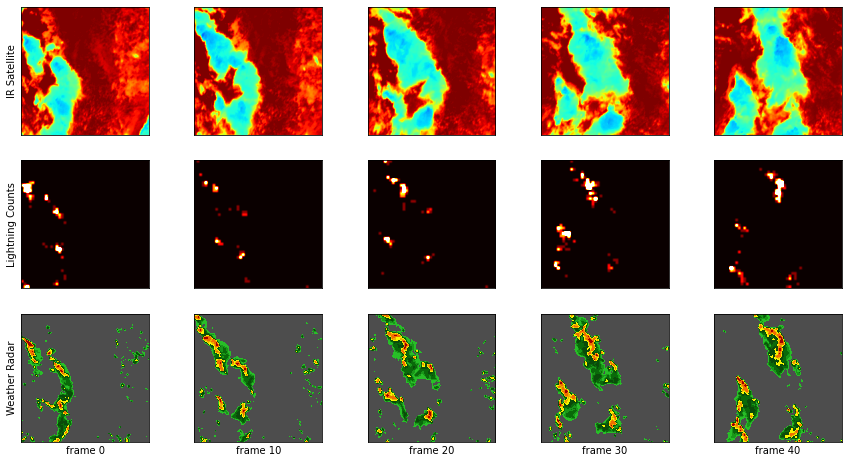

In [13]:
# View these
fig,axs=plt.subplots(3,5,figsize=(15,8))
cmap1,norm1,vmin1,vmax1 = get_cmap('ir107',encoded=True)
cmap2,norm2,vmin2,vmax2 = get_cmap('vil',encoded=True)
for i in [0,10,20,30,40]:
    axs[0][i//10].imshow( X[0][0,:,:,i],cmap=cmap1,norm=norm1,vmin=vmin1,vmax=vmax1)
    axs[0][i//10].set_xticks([], [])
    axs[0][i//10].set_yticks([], [])
    if i==0:axs[0][i//10].set_ylabel('IR Satellite')
        
    axs[1][i//10].imshow( X[1][0,:,:,i],cmap='hot',vmin=0,vmax=5)
    axs[1][i//10].set_xticks([], [])
    axs[1][i//10].set_yticks([], [])
    if i==0:axs[1][i//10].set_ylabel('Lightning Counts')
    
    axs[2][i//10].imshow( Y[0][0,:,:,i],cmap=cmap2,norm=norm2,vmin=vmin2,vmax=vmax2)
    axs[2][i//10].set_xticks([], [])
    axs[2][i//10].set_yticks([], [])
    if i==0:axs[2][i//10].set_ylabel('Weather Radar')
    axs[2][i//10].set_xlabel(f'frame {i}')

In [14]:
vil_ir_lght_seq.close()

#### Get single images (not movies)

In [15]:
# Can also "unwrap" the time dimension if you only want single images
# Because of this, we'll increase batch size and also shuffle so that images in a movie don't appear next
# to each other in the batches
vil_imgs = SEVIRGenerator(x_img_types=['vil'],
                         batch_size=256,
                         unwrap_time=True,
                         shuffle=True)

In [16]:
# Get a batch
X = vil_imgs.get_batch(1234)  # returns list the same size as x_img_types passed to constructor
X[0].shape # Now there is no time dimension

(256, 384, 384, 1)

In [17]:
vil_imgs.close()

#### Date filters

When doing train/test splits, spliting on date of the event is a natural way partition your data.  This can be done easily in SEVIR by adding some date filters to the constructor

In [18]:
import datetime
# Train on 2018 data, test on 2019 data
vil_img_train = SEVIRGenerator(x_img_types=['vil'],batch_size=256,unwrap_time=True,
                              start_date=datetime.datetime(2018,1,1),
                              end_date=datetime.datetime(2019,1,1))
vil_img_test = SEVIRGenerator(x_img_types=['vil'],batch_size=256,unwrap_time=True,
                              start_date=datetime.datetime(2019,1,1),
                              end_date=datetime.datetime(2020,1,1))

In [19]:
vil_img_train.close()
vil_img_test.close()

In [20]:
# The datetime_filter can let you carefully control what times are sampled.
vis_seq = SEVIRGenerator(x_img_types=['vis'],batch_size=32,unwrap_time=True,
                              start_date=datetime.datetime(2018,1,1),
                              end_date=datetime.datetime(2019,1,1),
                              datetime_filter=lambda t: np.logical_and(t.dt.hour>=13,t.dt.hour<=21))

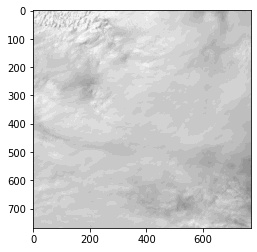

In [21]:
# images should all have day light for VIS satellite
X=vis_seq.get_batch(123)
cmap,norm,vmin,vmax = get_cmap('vis',encoded=True)
plt.imshow(X[0][0,:,:,0],cmap=cmap,norm=norm,vmin=vmin,vmax=vmax)

In [22]:
vis_seq.close()

### Load several batches at once

The `SEVIRGenerator` class can also be used to preload several batches at once. This makes sense if you have enough memory. This makes model training much faster since you are avoiding repeated data reads from disk.

In [23]:
import datetime
vil_gen = SEVIRGenerator(x_img_types=['vil'],batch_size=256,unwrap_time=True,
                        start_date=datetime.datetime(2018,1,1),
                        end_date=datetime.datetime(2019,1,1))

In [24]:
# Load 10 batches at once
X = vil_gen.load_batches(n_batches=10,progress_bar=True)

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


In [25]:
X[0].shape  # should have 256 * 10 samples

(2560, 384, 384, 1)